<a href="https://colab.research.google.com/github/michele-perrone/SpectrogramPlayer/blob/main/Source/Notebooks/NeMo_Spectrogram_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NeMo Spectrogram Testing**
This is a testing notebook. Here, we try to understand what are the exact arguments, outputs and parameters of the following methods:

*   `SpectrogramGenerator.generate_spectrogram(tokens=parsed)`
*   `Vocoder.convert_spectrogram_to_audio(spec=spectrogram)`

The goal is to use them independently, without running the entire end-to-end model.

# Final result

We ended up using this function as for the computation of the Mel-Spectrograms used by NeMo models:


In [4]:
import tensorflow as tf

class NemoSpec(tf.keras.Model):

  def __init__(self,
               sample_rate: int = 16000,
               n_fft: int = 1024,
               hop_length: int = 160,
               win_length: int = 400,
               n_mel_channels: int = 64,
               drop_dc: bool = True,
               mel_fmin: float = 60.0,
               mel_fmax: float = 7800.0,
               clip_value_min: float = 1e-5,
               clip_value_max: float = 1e8,
               log_amplitude: bool = True,
               n_mfcc_channels: int = None,
               postprocessing: bool = False,
               pad_to: int = 16,
               pad_value: float = -11.52):
    """
    Args:
      sample_rate: sampling rate. Need to be provided if `n_mel_channels` is not
        `None`.
      n_fft: length of the FFT, in samples.
      hop_length: length of the hop size, in samples.
      win_length: length of the window, in samples.
      n_mel_channels: number of mel channels. If set to None, will return the
        full magnitude STFT.
      drop_dc: if `True`, drop the STFT DC coefficient. Used only when
        n_mel_channels is `None`.
      mel_fmin: lowest frequency in the mel filterbank in Hz.
      mel_fmax: highest frequency in the mel filterbank in Hz.
      clip_value_min: minimal value of the (mel)-spectrogram before log. Used
        only when `log_amplitude` is `True`.
      clip_value_max: maximal value of the (mel)-spectrogram before log. Used
        only when `log_amplitude` is `True`.
      log_amplitude: if `True` apply log amplitude scaling.
      n_mfcc_channels: number of mfcc channels. If set to None, will return the
        full magnitude STFT or the mels.
    """

    super().__init__()

    self._n_fft = n_fft
    self._hop_length = hop_length
    self._win_length = win_length
    self._sample_rate = sample_rate
    self._clip_value_min = clip_value_min
    self._clip_value_max = clip_value_max
    self._log_amplitude = log_amplitude
    self._n_mel_channels = n_mel_channels
    self._n_mfcc_channels = n_mfcc_channels
    self._drop_dc = drop_dc
    self._postprocessing = postprocessing
    self._pad_to = pad_to
    self._pad_value = pad_value

    if n_mel_channels is None:
      self.mel_basis = None
    else:
      if sample_rate is None:
        raise ValueError(
            '`sample_rate` must be provided when `n_mel_channels` is not `None`'
        )
      if mel_fmax is None:
        mel_fmax = sample_rate // 2

      self.mel_basis = tf.convert_to_tensor(
          librosa.filters.mel(sample_rate, win_length, n_mels=n_mel_channels,
          fmin=mel_fmin, fmax=mel_fmax).T, dtype=tf.float32)

  def call(self, audio, training=False):
    """Computes the mel spectrogram of the input audio samples.

    Coefficients are clipped before log compression to avoid log(0) and large
    coefficients.

    Args:
      audio: input sample of shape (batch_size, num_samples).
      training: flag to distinguish between train and test time behavior.

    Returns:
      Mel spectrogram of shape (batch_size, time_frames, freq_bins).
    """
    fft = tf.signal.stft(
        audio,
        frame_length=self._win_length,
        frame_step=self._hop_length,
        fft_length=self._n_fft,
        window_fn=tf.signal.hann_window,
        pad_end=True)
    fft_modulus = tf.abs(fft)

    if self.mel_basis is not None:
      output = tf.matmul(fft_modulus, self.mel_basis)
    else:
      output = fft_modulus
      if self._drop_dc:
        output = output[:, :, 1:]

    if self._log_amplitude:
        output = tf.clip_by_value(
          output,
          clip_value_min=self._clip_value_min,
          clip_value_max=self._clip_value_max)
        output = tf.math.log(output)

    if self._n_mfcc_channels is not None:
      if self.mel_basis is None or self._n_mel_channels < self._n_mfcc_channels:
        raise ValueError('MFCCs require n_mel_channels >= n_mfcc_channels '
                         f'but n_mel_channels={self._n_mel_channels} '
                         f'and n_mfcc_channels={self._n_mfcc_channels}')
      if not self._log_amplitude:
        raise ValueError('MFCCs require log_amplitude=True')
      output = tf.signal.mfccs_from_log_mel_spectrograms(output)[
          ..., :self._n_mfcc_channels]

    if self._postprocessing:

        # pad to multiple of `pad_to` (for efficiency)
        pad_to = self._pad_to
        if pad_to == "max":
            output = np.pad(output, ((0,0), (0, self.max_length - output.shape[1]), (0,0)), constant_values=self._pad_value)
        elif pad_to > 0:
            pad_amt = output.shape[1] % pad_to
            if pad_amt != 0:
                output = np.pad(output, ((0,0), (0, pad_to - pad_amt), (0,0)), constant_values=self._pad_value)

    # Transpose output to the desired shape
    output = tf.transpose(output, perm=[0, 2, 1])

    return output

In [5]:
extractMel = NemoSpec(sample_rate=22050,
           n_fft=1024,
           hop_length=256,
           win_length=1024,
           n_mel_channels=80,
           mel_fmin=0,
           mel_fmax=8000,
           clip_value_min=1e-5,
           clip_value_max=1e8,
           log_amplitude=True,
           n_mfcc_channels=None,
           postprocessing=False)

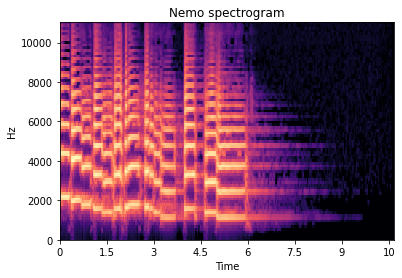

In [17]:
# Demo call:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import librosa.display

signal, sr = librosa.load(librosa.ex('trumpet'))

signal = signal[None,:]
nemo_spectrogram = extractMel.call(signal)
nemo_spectrogram = np.squeeze(nemo_spectrogram, axis=0)

plt.title('Nemo spectrogram')
librosa.display.specshow(nemo_spectrogram, y_axis='linear', x_axis='time');


# Our tests

In [ ]:
# Install NeMo

!pip install nemo-toolkit[all]

In [ ]:
# NeMo imports

import soundfile as sf
from nemo.collections.tts.models.base import SpectrogramGenerator, Vocoder

In [ ]:
# Generic imports

import matplotlib as plt
import numpy as np 
import matplotlib.pyplot as plt
import librosa, librosa.display
import IPython.display as ipd
import pathlib
import warnings
import random
import os
import torch

In [ ]:
# Download and load the pretrained fastpitch model
spec_generator = SpectrogramGenerator.from_pretrained(model_name="tts_en_fastpitch").cuda()
# Download and load the pretrained hifigan model
vocoder = Vocoder.from_pretrained(model_name="tts_squeezewave").cuda()

# All spectrogram generators start by parsing raw strings to a tokenized version of the string
parsed = spec_generator.parse("Let's see the difference between the spectrograms. Aaaaaaaaaaaaaaaaaaaaaa")
# They then take the tokenized string and produce a spectrogram
spectrogram = spec_generator.generate_spectrogram(tokens=parsed)
# Finally, a vocoder converts the spectrogram to audio
audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)

In [ ]:
# Save the audio to disk in a file called speech.wav
# Note vocoder return a batch of audio. In this example, we just take the first and only sample.
sr = 22050
audio_numpy = audio.to('cpu').detach().numpy()[0]
sf.write("speech.wav", audio_numpy, sr)

# Play back the audio
ipd.Audio(audio_numpy, rate = sr)

In [ ]:
# NeMo STFT and MEL parameters:
sample_rate = 22050
n_fft = 1024
win_length = 1024
hop_length = 256
window = 'hann'
n_mels = 80
lowfreq = 0
highfreq = 8000
num_ceps = 20 # THIS IS FOR PLOTTING THE MFCCs WITH LIBROSA

spectrogram.shape: torch.Size([1, 80, 409]), spectrogram_np.shape: (80, 409)




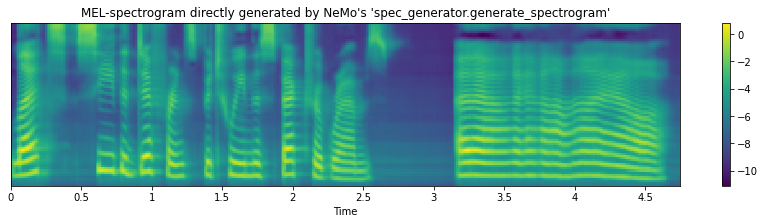

In [ ]:
# Analize the spectrogram that was generated by the method:
# 'SpectrogramGenerator.generate_spectrogram'
# 1. See if it's an STFT or a MEL spectrogram
# 2. See if the phase is present or not

# First step: analyze the shape of the NeMo spectrogram
# Judging from the shape, we're dealing with a MEL spectrogram.
spectrogram_np = spectrogram.to('cpu').detach().numpy()[0]
print("spectrogram.shape: {}, spectrogram_np.shape: {}\n\n" .format(spectrogram.shape, spectrogram_np.shape))

# Second step: plot the NeMo spectrogram
# WHAT WE LEARN FROM THIS: The Nemo spectrogram IS ALREADY IN DECIBELS!!!
# Which means that "S = spectrogram_np", and NOT "S = librosa.power_to_db(spectrogram_np)"
plt.figure(figsize=(15, 3))
plt.title("MEL-spectrogram directly generated by NeMo's 'spec_generator.generate_spectrogram'")
librosa.display.specshow(spectrogram_np, sr=sr, hop_length=hop_length, x_axis='time', cmap='viridis')
plt.colorbar();

audio_numpy.shape: (104704,), X_mel.shape: (80, 410), X_mfcc.shape: (20, 410)




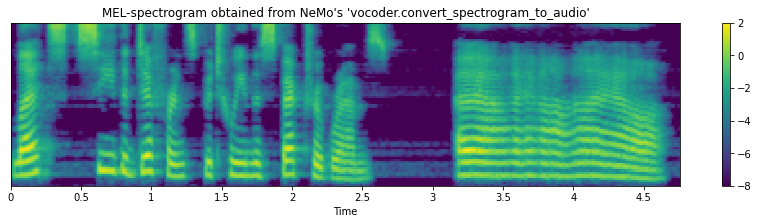

In [ ]:
# Starting from the audio generated by the method:
# 'vocoder.convert_spectrogram_to_audio'
# Try to recreate the same spectrogram that was generated by the method:
# 'SpectrogramGenerator.generate_spectrogram'

X = librosa.stft(audio_numpy, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)
X_mag = np.abs(X)**2
X_mel = librosa.feature.melspectrogram(S=X_mag, sr=sample_rate, n_fft=n_fft,
                                       hop_length=hop_length, n_mels=n_mels,
                                       fmin=lowfreq, fmax=highfreq)


# Second step: plot the NeMo spectrogram
X_mel = np.log10(np.clip(X_mel, a_min=1e-8, a_max=None))
plt.figure(figsize=(15, 3))
plt.title("MEL-spectrogram obtained from NeMo's 'vocoder.convert_spectrogram_to_audio'")
librosa.display.specshow(X_mel, sr=sr, hop_length=hop_length, x_axis='time', cmap='viridis')
plt.colorbar();

print("audio_numpy.shape: {}, X_mel.shape: {}, X_mfcc.shape: {}\n\n" .format(audio_numpy.shape, X_mel.shape, X_mfcc.shape))

In [ ]:
# Starting from the Mel-Spectrogram created by Librosa,
# use NeMo to generate the audio clip, and play it back.

spectrogram_2 = librosa.power_to_db(S=X_mel)/5 # THIS IS CRUCIAL
spectrogram_2 = torch.tensor(spectrogram_2).cuda().unsqueeze(dim=0)
print("spectrogram.shape: {}, spectrogram_2.shape: {}\n\n" .format(spectrogram.shape, spectrogram_2.shape))

audio_2 = vocoder.convert_spectrogram_to_audio(spec=spectrogram_2)

audio_2_numpy = audio_2.to('cpu').detach().numpy()[0]
ipd.Audio(audio_2_numpy, rate = sr)

spectrogram.shape: torch.Size([1, 80, 409]), spectrogram_2.shape: torch.Size([1, 80, 410])


